In [1]:
import os
import shutil
import random

# Set the path to the original directory containing all the food class images
original_data_dir = '/kaggle/input/food-img-class/FoodImage'

# Set the paths to the directories where you want to create the train, validation, and test datasets
train_dir = '/kaggle/working/food_train'

validation_dir = '/kaggle/working/food_val'
test_dir = '/kaggle/working/food_test'

# Set the percentage of data you want for training, validation, and test datasets
train_percentage = 0.7
validation_percentage = 0.20
test_percentage = 0.10

# Create the train, validation, and test directories if they don't exist
os.makedirs(train_dir, exist_ok=True)
os.makedirs(validation_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Loop over each food class directory
for class_name in os.listdir(original_data_dir):
    class_dir = os.path.join(original_data_dir, class_name)
    
    # Create the class directories in train, validation, and test
    train_class_dir = os.path.join(train_dir, class_name)
    validation_class_dir = os.path.join(validation_dir, class_name)
    test_class_dir = os.path.join(test_dir, class_name)
    os.makedirs(train_class_dir, exist_ok=True)
    os.makedirs(validation_class_dir, exist_ok=True)
    os.makedirs(test_class_dir, exist_ok=True)
    
    # Get the list of image files in the class directory
    image_files = os.listdir(class_dir)
    random.shuffle(image_files)
    
    # Split the image files into train, validation, and test sets
    num_images = len(image_files)
    num_train = int(train_percentage * num_images)
    num_validation = int(validation_percentage * num_images)
    num_test = num_images - num_train - num_validation
    
    train_files = image_files[:num_train]
    validation_files = image_files[num_train:num_train + num_validation]
    test_files = image_files[num_train + num_validation:]
    
    # Move the image files to the corresponding directories
    for train_file in train_files:
        src = os.path.join(class_dir, train_file)
        dst = os.path.join(train_class_dir, train_file)
        shutil.copyfile(src, dst)
    
    for validation_file in validation_files:
        src = os.path.join(class_dir, validation_file)
        dst = os.path.join(validation_class_dir, validation_file)
        shutil.copyfile(src, dst)
    
    for test_file in test_files:
        src = os.path.join(class_dir, test_file)
        dst = os.path.join(test_class_dir, test_file)
        shutil.copyfile(src, dst)

In [2]:
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [10]:
import tensorflow as tf

# Initialize GPUs
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Set memory growth to True for all GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)


2 Physical GPUs, 2 Logical GPUs


In [11]:
train_dir = '/kaggle/working/food_train'
validation_dir = '/kaggle/working/food_val'
test_dir = '/kaggle/working/food_test'


In [12]:
image_size = 224
batch_size = 8

# Set the data augmentation parameters
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,  # Random rotation within the range of 20 degrees
    width_shift_range=0.2,  # Randomly shift the width by 20% of the total width
    height_shift_range=0.2,  # Randomly shift the height by 20% of the total height
    shear_range=0.2,  # Random shearing within the range of 20 degrees
    zoom_range=0.2,  # Random zooming within the range of 20%
    horizontal_flip=True)  # Random horizontal flipping


train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='categorical')

validation_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='categorical')

Found 345 images belonging to 6 classes.
Found 97 images belonging to 6 classes.


In [13]:
import numpy as np

# Calculate class weights for imbalance handling
class_counts = train_generator.classes
epsilon = 1e-7
class_weights = dict(enumerate((np.max(class_counts) / (class_counts + epsilon))))


In [14]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
num_classes = 6

model = Sequential()
#model.add(ResNet50(include_top=False, weights=None, pooling='avg'))
model.add(ResNet50(include_top=False, pooling='avg', weights='imagenet'))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
# Set the learning rate
learning_rate = 0.0001
model.layers[0].trainable = True
optimizer = Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])


94765736/94765736 [==============================] - 1s 0us/step


In [15]:
# Set up early stopping
early_stop = EarlyStopping(patience=10, monitor='val_loss', restore_best_weights=True)

# Train the model with early stopping
epochs = 40
steps_per_epoch = len(train_generator)
validation_steps = len(validation_generator)

model.fit_generator(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    callbacks=[early_stop])


/tmp/ipykernel_28/2282480576.py:9: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(


Epoch 1/40
44/44 [==============================] - 65s 348ms/step - loss: 1.2416 - accuracy: 0.5333 - val_loss: 0.1881 - val_accuracy: 0.9485
Epoch 2/40
44/44 [==============================] - 13s 297ms/step - loss: 0.3804 - accuracy: 0.8957 - val_loss: 0.3497 - val_accuracy: 0.9278
Epoch 3/40
44/44 [==============================] - 13s 287ms/step - loss: 0.2756 - accuracy: 0.9159 - val_loss: 0.4399 - val_accuracy: 0.9072
Epoch 4/40
44/44 [==============================] - 13s 299ms/step - loss: 0.2084 - accuracy: 0.9275 - val_loss: 0.4297 - val_accuracy: 0.9175
Epoch 5/40
44/44 [==============================] - 13s 289ms/step - loss: 0.2235 - accuracy: 0.9304 - val_loss: 0.7132 - val_accuracy: 0.8351
Epoch 6/40
44/44 [==============================] - 14s 308ms/step - loss: 0.2818 - accuracy: 0.9101 - val_loss: 0.6400 - val_accuracy: 0.8660
Epoch 7/40
44/44 [==============================] - 13s 286ms/step - loss: 0.2225 - accuracy: 0.9362 - val_loss: 0.5835 - val_accuracy: 0.8660

In [16]:
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False)

scores = model.evaluate_generator(test_generator, len(test_generator))
print("Test loss:", scores[0])
print("Test accuracy:", scores[1])


Found 55 images belonging to 6 classes.


/tmp/ipykernel_28/415143990.py:10: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  scores = model.evaluate_generator(test_generator, len(test_generator))


Test loss: 0.14491331577301025
Test accuracy: 0.9454545378684998


In [21]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50

# Rest of the code for data preprocessing, model building, and training

# Function to predict an image class
def predict_image(img_path):
    image_size = (224, 224)  # Adjust this size if needed
    img = load_img(img_path, target_size=image_size)
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)

    # Make predictions using the trained model
    predictions = model.predict(x)
    class_indices = train_generator.class_indices
    predicted_class = list(class_indices.keys())[np.argmax(predictions)]

    return predicted_class

# Provide a list of test image paths
test_images = [
    '/kaggle/working/food_test/Pork/B070220XX_11085.jpg',
    '/kaggle/working/food_test/ApplePie/A020511XX_02688.jpg',
    '/kaggle/working/food_test/Bread/A020118XX_11000.jpg',
    '/kaggle/working/food_test/FriedRice/B010443XX_10223.jpg',
    '/kaggle/working/food_test/BagelSandwich/B020411XX_11195.jpg',
    '/kaggle/working/food_test/ApplePie/A020511XX_02594.jpg'
]
# Predict and print the class of each test image
for img_path in test_images:
    predicted_class = predict_image(img_path)
    print(f"Image: {img_path}")
    print(f"Predicted class: {predicted_class}")





1/1 [==============================] - 1s 966ms/step
Image: /kaggle/working/food_test/Pork/B070220XX_11085.jpg
Predicted class: Pork
1/1 [==============================] - 0s 25ms/step
Image: /kaggle/working/food_test/ApplePie/A020511XX_02688.jpg
Predicted class: ApplePie
1/1 [==============================] - 0s 26ms/step
Image: /kaggle/working/food_test/Bread/A020118XX_11000.jpg
Predicted class: Bread
1/1 [==============================] - 0s 23ms/step
Image: /kaggle/working/food_test/FriedRice/B010443XX_10223.jpg
Predicted class: FriedRice
1/1 [==============================] - 0s 24ms/step
Image: /kaggle/working/food_test/BagelSandwich/B020411XX_11195.jpg
Predicted class: BagelSandwich
1/1 [==============================] - 0s 24ms/step
Image: /kaggle/working/food_test/ApplePie/A020511XX_02594.jpg
Predicted class: ApplePie


1/1 [==============================] - 0s 24ms/step


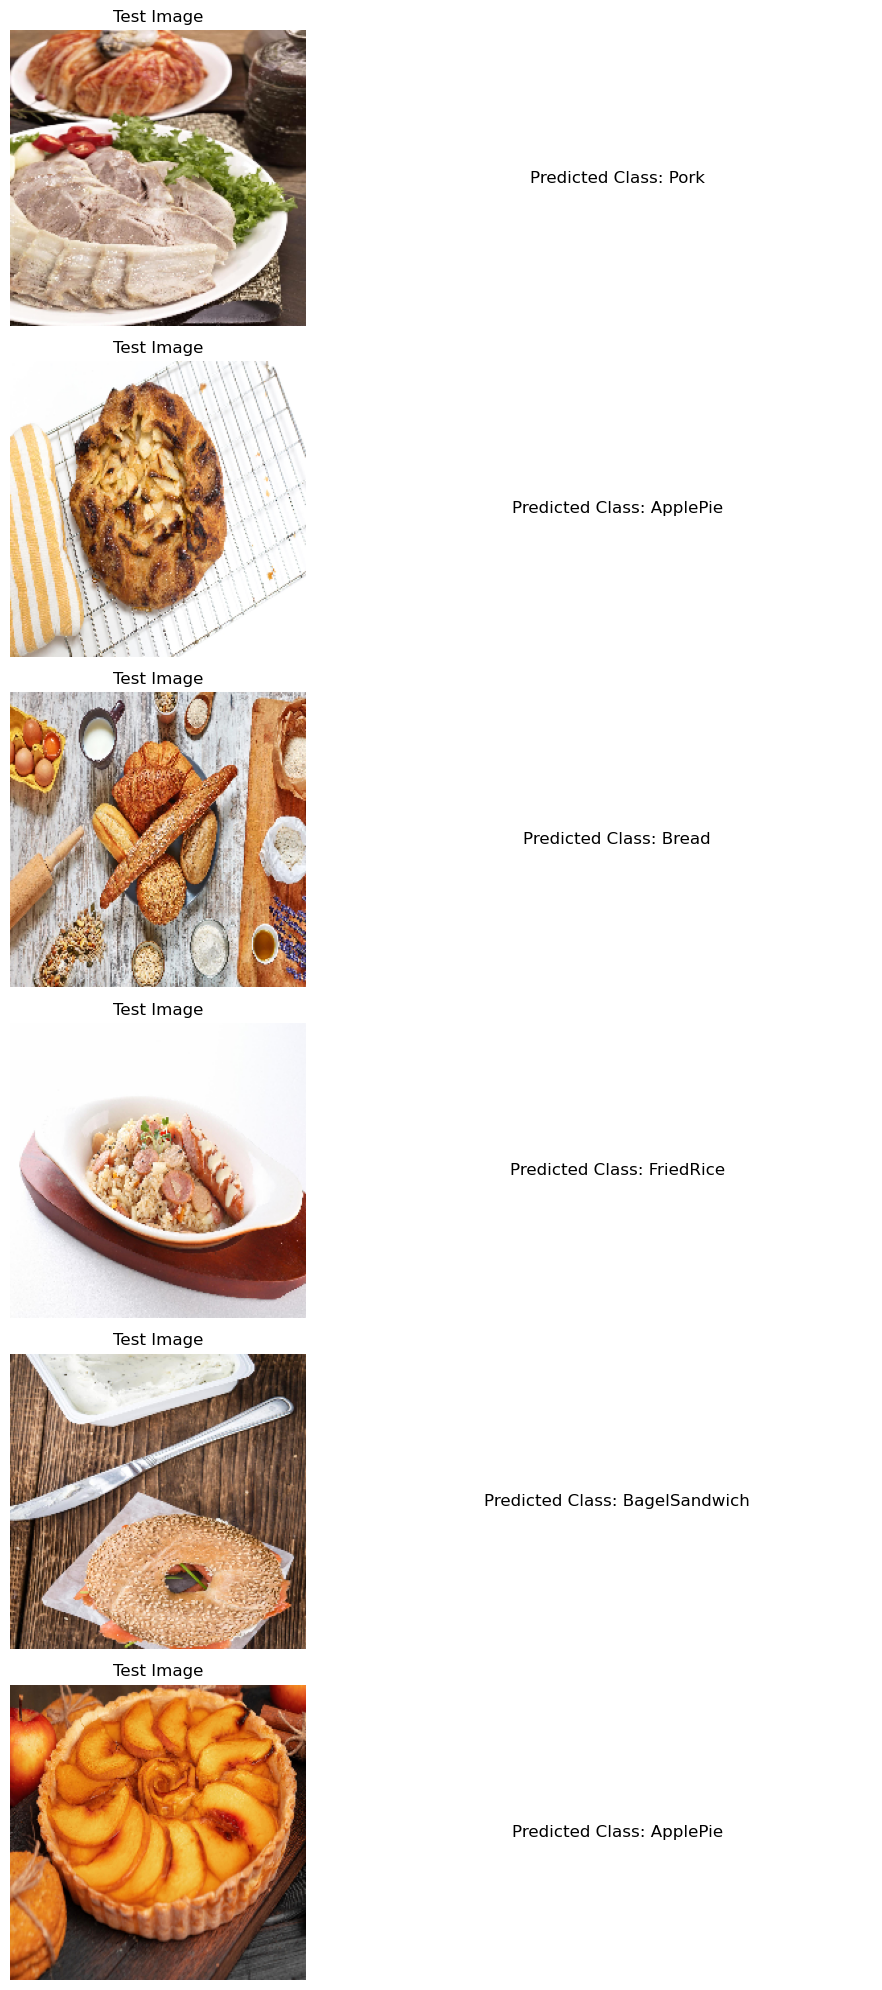

In [22]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50
import matplotlib.pyplot as plt

# Rest of the code for data preprocessing, model building, and training

# Function to predict an image class
def predict_image(img_path):
    image_size = (224, 224)  # Adjust this size if needed
    img = load_img(img_path, target_size=image_size)
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)

    # Make predictions using the trained model
    predictions = model.predict(x)
    class_indices = train_generator.class_indices
    predicted_class = list(class_indices.keys())[np.argmax(predictions)]

    return img, predicted_class

# Provide a list of test image paths
# Provide a list of test image paths
test_images = [
    '/kaggle/working/food_test/Pork/B070220XX_11085.jpg',
    '/kaggle/working/food_test/ApplePie/A020511XX_02688.jpg',
    '/kaggle/working/food_test/Bread/A020118XX_11000.jpg',
    '/kaggle/working/food_test/FriedRice/B010443XX_10223.jpg',
    '/kaggle/working/food_test/BagelSandwich/B020411XX_11195.jpg',
    '/kaggle/working/food_test/ApplePie/A020511XX_02594.jpg'
]

# Predict and plot the class of each test image
num_rows = len(test_images)
num_cols = 2
fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 20))

for i, img_path in enumerate(test_images):
    img, predicted_class = predict_image(img_path)
    
    # Plot the image
    axes[i, 0].imshow(img)
    axes[i, 0].axis('off')
    axes[i, 0].set_title('Test Image')

    # Plot the predicted class
    axes[i, 1].text(0.5, 0.5, f'Predicted Class: {predicted_class}', ha='center', va='center', fontsize=12)
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()
